In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


Resample Data to 60 minutes interval

In [2]:
mtalbert_daily = mtalbert.resample('D').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

In [3]:
mtalbert_daily.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07,0.00,11.064706,37.337412
2018-07-08,7.36,11.355208,36.910969
2018-07-09,19.99,12.148958,40.972479
2018-07-10,7.88,11.923958,42.747948
2018-07-11,0.53,11.422581,42.727272


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [6]:
mtalbert_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2299 entries, 2018-07-07 to 2024-10-21
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         2299 non-null   float64
 1   SoilTemp(c)      1961 non-null   float64
 2   SoilMoisture(%)  1961 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


In [7]:
mtalbert_daily.isna().sum()


Rain(mm)             0
SoilTemp(c)        338
SoilMoisture(%)    338
dtype: int64

In [8]:
mtalbert_daily = mtalbert_daily.dropna(subset=['SoilTemp(c)', 'SoilMoisture(%)'])
mtalbert_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1961 entries, 2018-07-07 to 2024-10-21
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         1961 non-null   float64
 1   SoilTemp(c)      1961 non-null   float64
 2   SoilMoisture(%)  1961 non-null   float64
dtypes: float64(3)
memory usage: 61.3 KB


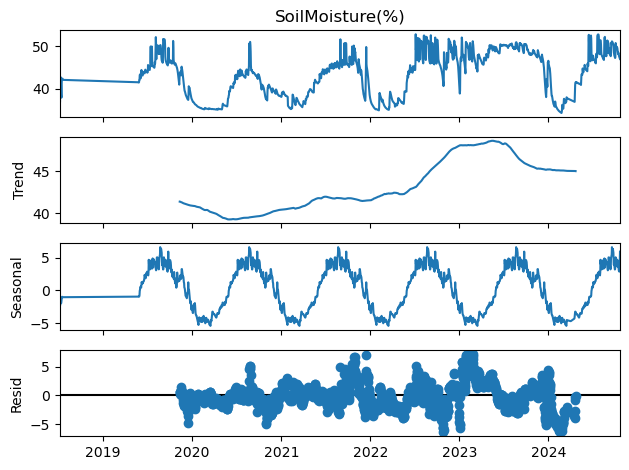

In [9]:
mtalbert_daily.index = pd.to_datetime(mtalbert_daily.index)
period = 365

result = seasonal_decompose(mtalbert_daily['SoilMoisture(%)'], model='add', period=period)
result.plot()
plt.show()

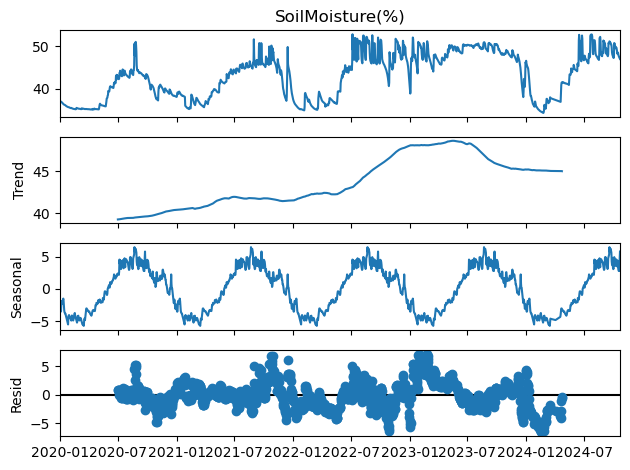

In [10]:
mtalbert_filtered = mtalbert_daily.loc['2020-01-01':]
period = 365 

result = seasonal_decompose(mtalbert_filtered['SoilMoisture(%)'], model='add', period=period)
result.plot()
plt.show()

<Axes: xlabel='Timestamp (UTC+12:00)'>

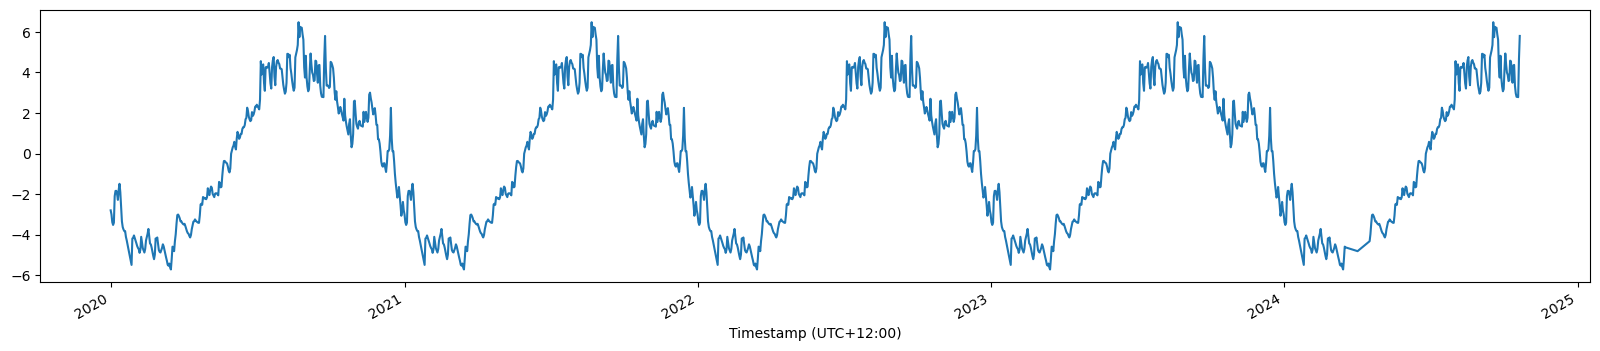

In [11]:
result.seasonal.plot(figsize=(20,4))

In [19]:
new_df = result.seasonal

new_df

Timestamp (UTC+12:00)
2020-01-01   -2.805531
2020-01-02   -3.006502
2020-01-03   -3.390068
2020-01-04   -3.524746
2020-01-05   -3.412972
                ...   
2024-10-17    2.799477
2024-10-18    2.822652
2024-10-19    2.781143
2024-10-20    4.661854
2024-10-21    5.803018
Name: seasonal, Length: 1728, dtype: float64

In [13]:
24 * 365 /4
# Winter: 90 days (December to February)
# Spring: 92 days (March to May)
# Summer: 92 days (June to August)
# Autumn: 91 days (September to November)

2190.0

this to find the p, d, q and P,D, Q
- check model, check AIC

In [49]:
auto_arima(mtalbert_daily['SoilMoisture(%)'], seasonal=True, m=365 ).summary()

In [ ]:
train_len = len(mtalbert_daily) * 0.8
train_len

1568.8000000000002

In [ ]:
train = mtalbert_daily.iloc[:1568]
test = mtalbert_daily.iloc[1568:]

In [ ]:
model = SARIMAX(train['SoilMoisture(%)'], order=(0,1,2))

c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
results = model.fit()
result

Predictive Model

In [ ]:
start = len(train)
end = len(train) + len(test) -1

In [ ]:
# train = mtalbert[['Rain(mm)', 'SoilTemp(c)']]
# test = mtalbert[['SoilMoisture(%)']]

In [ ]:
sarima_predictions = results.predict(start, end, typ="levels").rename('Sarima Predictions')

c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='Timestamp (UTC+12:00)'>

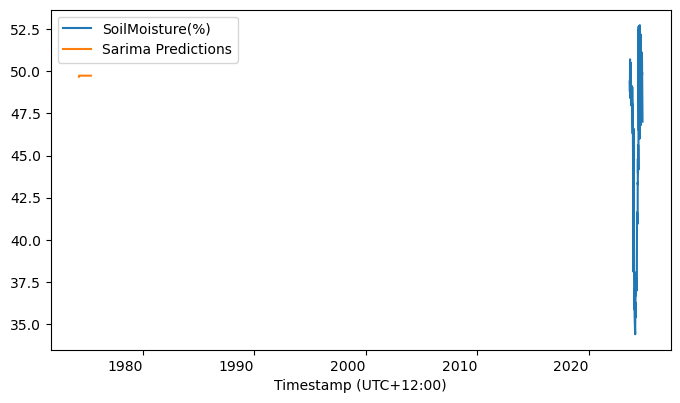

In [ ]:
test['SoilMoisture(%)'].plot(legend=True, figsize=(8,5))
sarima_predictions.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

sa_mae, sa_mse, sa_rmse, sa_r2 = evaluate_model(sarima_predictions, test['SoilMoisture(%)'])

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {sa_mae}")
print(f"MSE: {sa_mse}")
print(f"RMSE: {sa_rmse}")
print(f"R2 Score: {sa_r2}")


Random Forest Testing Set Metrics:
MAE: 4.847868969358817
MSE: 45.381063669533034
RMSE: 6.736546865385339
R2 Score: -0.7462826112236427


Forecast into the unknown future

In [ ]:
model = SARIMAX(mtalbert_daily['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))
result = model.fit()

c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
fcast = results.predict(len(mtalbert_daily), len(mtalbert_daily) + 24)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
